# CS-4824 Intro to Machine Learning
# Rohan Jaggannagari
# Final Project: Anime Machine Learning
Note: sources.txt shows which sources were used for this project

## Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA
from math import dist

## Read in the data
I read in the data that was cleaned from the other script.

In [2]:
warnings.simplefilter("ignore")

anime_df = pd.read_csv("clean_data/clean_anime_data.csv")
pd.set_option('display.max_columns', 150) # Wanted to see all of the columns

# Getting rid of these columns as of now, but may add them back if I can process them in a proper way
drop_columns = ['English name', 'Synopsis', 'Duration', 'Unnamed: 0', 'Producers', 'Studios']
anime_df = anime_df.drop(columns = drop_columns)
anime_df.set_index('Name', inplace = True)

# Get rid of row with null values
anime_df = anime_df.dropna()

anime_df.head(5)

,Score,Genres,Type,Episodes,Licensors,Source,Rating
Name,,,,,,,
Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi",TV,26.0,"Funimation, Bandai Entertainment",Original,R - 17+ (violence & profanity)
Cowboy Bebop: Tengoku no Tobira,8.38,"Action, Sci-Fi",Movie,1.0,Sony Pictures Entertainment,Original,R - 17+ (violence & profanity)
Trigun,8.22,"Action, Adventure, Sci-Fi",TV,26.0,"Funimation, Geneon Entertainment USA",Manga,PG-13 - Teens 13 or older
Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",TV,26.0,"Funimation, Bandai Entertainment",Original,PG-13 - Teens 13 or older
Bouken Ou Beet,6.94,"Adventure, Fantasy, Supernatural",TV,52.0,Illumitoon Entertainment,Manga,PG - Children


## Data Processing

### Make episodes all int and reducing their weights
I need to get rid of any of the rows that do not have episodes since that goes into my machine learning algorithm. An alternative could have been to give those rows a standardized number, but I decided against that. Also, I need to reduce the weights of the episodes since it is calculated using the euclidean distance. 

In [3]:
anime_df['Episodes'] = anime_df['Episodes'].astype(float)
anime_df['Episodes'] = anime_df['Episodes'] * 0.05

anime_df.head(5)

,Score,Genres,Type,Episodes,Licensors,Source,Rating
Name,,,,,,,
Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi",TV,1.30,"Funimation, Bandai Entertainment",Original,R - 17+ (violence & profanity)
Cowboy Bebop: Tengoku no Tobira,8.38,"Action, Sci-Fi",Movie,0.05,Sony Pictures Entertainment,Original,R - 17+ (violence & profanity)
Trigun,8.22,"Action, Adventure, Sci-Fi",TV,1.30,"Funimation, Geneon Entertainment USA",Manga,PG-13 - Teens 13 or older
Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",TV,1.30,"Funimation, Bandai Entertainment",Original,PG-13 - Teens 13 or older
Bouken Ou Beet,6.94,"Adventure, Fantasy, Supernatural",TV,2.60,Illumitoon Entertainment,Manga,PG - Children


### Increase the weight for the score
I want to increase the weight for the score so that it is weighted more. The point of the project is personalization and I am someone that wants score higher.

In [4]:
anime_df['Score'] = anime_df['Score'] * 5
anime_df.head(5)

,Score,Genres,Type,Episodes,Licensors,Source,Rating
Name,,,,,,,
Cowboy Bebop,43.75,"Action, Award Winning, Sci-Fi",TV,1.30,"Funimation, Bandai Entertainment",Original,R - 17+ (violence & profanity)
Cowboy Bebop: Tengoku no Tobira,41.90,"Action, Sci-Fi",Movie,0.05,Sony Pictures Entertainment,Original,R - 17+ (violence & profanity)
Trigun,41.10,"Action, Adventure, Sci-Fi",TV,1.30,"Funimation, Geneon Entertainment USA",Manga,PG-13 - Teens 13 or older
Witch Hunter Robin,36.25,"Action, Drama, Mystery, Supernatural",TV,1.30,"Funimation, Bandai Entertainment",Original,PG-13 - Teens 13 or older
Bouken Ou Beet,34.70,"Adventure, Fantasy, Supernatural",TV,2.60,Illumitoon Entertainment,Manga,PG - Children


### Encoding ratings
Ratings is a scale so the gaosl is to start all ages as 0 and R+ as higher so the recomendation system accounts for that. I could have used a label encoder, but it would have randomly assigned those values and I needed there to be a followed pattern for it.

In [5]:
# All the categories that are possible
rating_categories = ['G - All Ages', 'PG - Children', 'PG-13 - Teens 13 or older', 'R - 17+ (violence & profanity)', 
                     'R+ - Mild Nudity', 'UNKNOWN']

rating_encoded = list() # Empty list that is going to be added too

# Iterate through each row and find append to a list
for i, current_row in anime_df.iterrows():
    if (current_row['Rating'] == rating_categories[0]):
        rating_encoded.append(0)
    elif (current_row['Rating'] == rating_categories[1]):
        rating_encoded.append(1)
    elif (current_row['Rating'] == rating_categories[2]):
        rating_encoded.append(2)
    elif (current_row['Rating'] == rating_categories[3]):
        rating_encoded.append(3)   
    elif (current_row['Rating'] == rating_categories[4]):
        rating_encoded.append(4)
    elif (current_row['Rating'] == rating_categories[5]):
        rating_encoded.append(5)

# Add the list as a column and drop the old ratings columns as it is not needed
anime_df['Rating Encoded'] = rating_encoded
anime_df = anime_df.drop(columns = 'Rating')

anime_df.head(5)

,Score,Genres,Type,Episodes,Licensors,Source,Rating Encoded
Name,,,,,,,
Cowboy Bebop,43.75,"Action, Award Winning, Sci-Fi",TV,1.30,"Funimation, Bandai Entertainment",Original,3
Cowboy Bebop: Tengoku no Tobira,41.90,"Action, Sci-Fi",Movie,0.05,Sony Pictures Entertainment,Original,3
Trigun,41.10,"Action, Adventure, Sci-Fi",TV,1.30,"Funimation, Geneon Entertainment USA",Manga,2
Witch Hunter Robin,36.25,"Action, Drama, Mystery, Supernatural",TV,1.30,"Funimation, Bandai Entertainment",Original,2
Bouken Ou Beet,34.70,"Adventure, Fantasy, Supernatural",TV,2.60,Illumitoon Entertainment,Manga,1


### Total genres
I need to get all of the genres to see how many unique ones there are. Depending on how many genres there are that is how many dimensions will be added to the dataframe. 

In [6]:
total_genres = list()

for i, current_row in anime_df.iterrows():
    # Need to put the genres in a list
    split_genres = current_row['Genres'].split(',')
    
    # Iterate through the genres in the the row
    for g in range (0, len(split_genres)):
        # Get rid of any leading white space
        split_genres[g] = split_genres[g].strip()
        
        # Add the unique ones
        if (split_genres[g] not in total_genres):
            total_genres.append(split_genres[g])

print("All genres: " + str(total_genres))
print("Number of genres: " + str(len(total_genres)))

All genres: ['Action', 'Award Winning', 'Sci-Fi', 'Adventure', 'Drama', 'Mystery', 'Supernatural', 'Fantasy', 'Comedy', 'Romance', 'Suspense', 'Sports', 'Ecchi', 'Gourmet', 'Avant Garde', 'Horror', 'Slice of Life', 'Girls Love', 'Boys Love', 'UNKNOWN', 'Erotica']
Number of genres: 21


### Total licensors
I need to get all of the licensors to see how many unique ones there are. Depending on how many licensors there are that is many dimensions will be added to the dataframe.

In [7]:
total_licensors = list()

for i, current_row in anime_df.iterrows():
    # Need to put the licensors in a list
    split_licensors = current_row['Licensors'].split(',')
    
    # Iterate through the licensors in the the row
    for g in range (0, len(split_licensors)):
        # Get rid of any leading white space
        split_licensors[g] = split_licensors[g].strip()
        
        # Add the unique ones
        if (split_licensors[g] not in total_licensors):
            total_licensors.append(split_licensors[g])

print("All licensors: " + str(total_licensors))
print("Number of licensors: " + str(len(total_licensors)))

All licensors: ['Funimation', 'Bandai Entertainment', 'Sony Pictures Entertainment', 'Geneon Entertainment USA', 'Illumitoon Entertainment', 'VIZ Media', 'Discotek Media', 'Nozomi Entertainment', 'ADV Films', 'GKIDS', 'Manga Entertainment', 'Media Blasters', 'NYAV Post', 'Aniplex of America', 'AnimEigo', 'Sentai Filmworks', 'UNKNOWN', 'Kadokawa Pictures USA', '4Kids Entertainment', 'Maiden Japan', 'Central Park Media', 'Flatiron Film Company', 'Tokyopop', 'Disney Platform Distribution', 'Harmony Gold', 'Synch-Point', 'Nelvana', 'NIS America', 'Inc.', 'Bandai Visual USA', 'AN Entertainment', 'Urban Vision', 'DreamWorks', 'Warner Bros. Pictures', 'DiC Entertainment', 'Enoki Films', 'Saban Entertainment', 'Crimson Star Media', 'Super Techno Arts', 'Kitty Media', 'Anchor Bay Films', 'Crunchyroll', 'Bandai', 'Eleven Arts', 'Miramax Films', 'Streamline Pictures', 'Shout! Factory', 'The Pokemon Company International', 'Voyager Entertainment', 'Konami Cross Media NY', 'Anime Midstream', 'Hasbr

### Total type
I need to get all of the sources to see how many unique ones there are. Depending on how many sources there are that is how many dimensions will be added to the dataframe.

In [8]:
total_types = list(anime_df['Type'].unique())

print("All types: " + str(total_types))
print("Number of types: " + str(len(total_types)))

All types: ['TV', 'Movie', 'OVA', 'Special', 'ONA', 'Music', 'UNKNOWN']
Number of types: 7


### Total sources
I need to get all of the types to see how many unique ones there are. Depending on how many types there are that is how many dimensions will be added to the dataframe.

In [9]:
total_sources = list(anime_df['Source'].unique())

print("All types: " + str(total_sources))
print("Number of types: " + str(len(total_sources)))

All types: ['Original', 'Manga', 'Light novel', 'Visual novel', '4-koma manga', 'Novel', 'Other', 'Game', 'Picture book', 'Unknown', 'Book', 'Music', 'Card game', 'Radio', 'Mixed media', 'Web manga', 'Web novel']
Number of types: 17


### One hot encoding

#### Genre
I needed to create a new column for each genre so that I can cluster it properly later. I would have used the sklearn library, but it would have created a unique one for combination. This way of doing it manually makes it easier to analyze.

In [10]:
# Add a column for each genre and set it to 0
for genre in total_genres:
    anime_df[genre] = 0
    
for i, current_row in anime_df.iterrows():
    split_genres = current_row['Genres'].split(',')
    
    for f in range (0, len(split_genres)):
        split_genres[f] = split_genres[f].strip()
        
        # If found, set that genre column to 1
        if (split_genres[f] in split_genres):
            anime_df.at[i, split_genres[f]] += 1

# Get rid of the original column
anime_df = anime_df.drop(columns = 'Genres')

anime_df.head(5)

,Score,Type,Episodes,Licensors,Source,Rating Encoded,Action,Award Winning,Sci-Fi,Adventure,Drama,Mystery,Supernatural,Fantasy,Comedy,Romance,Suspense,Sports,Ecchi,Gourmet,Avant Garde,Horror,Slice of Life,Girls Love,Boys Love,UNKNOWN,Erotica
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cowboy Bebop,43.75,TV,1.30,"Funimation, Bandai Entertainment",Original,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cowboy Bebop: Tengoku no Tobira,41.90,Movie,0.05,Sony Pictures Entertainment,Original,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Trigun,41.10,TV,1.30,"Funimation, Geneon Entertainment USA",Manga,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Witch Hunter Robin,36.25,TV,1.30,"Funimation, Bandai Entertainment",Original,2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bouken Ou Beet,34.70,TV,2.60,Illumitoon Entertainment,Manga,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Licensors
I needed to one hot encode all of the licensors so that I can cluster it more accurately.

In [11]:
# Add a column for each genre and set it to 0
for licensors in total_licensors:
    if (licensors != 'UNKNOWN'):
        anime_df[licensors] = 0
    
for i, current_row in anime_df.iterrows():
    split_licensors = current_row['Licensors'].split(',')
    
    for f in range (0, len(split_licensors)):
        split_licensors[f] = split_licensors[f].strip()
        
        # If found, set that genre column to 1
        if (split_licensors[f] in split_licensors):
            anime_df.at[i, split_licensors[f]] += 1

# Get rid of the original column
anime_df = anime_df.drop(columns = 'Licensors')

anime_df.head(5)

,Score,Type,Episodes,Source,Rating Encoded,Action,Award Winning,Sci-Fi,Adventure,Drama,Mystery,Supernatural,Fantasy,Comedy,Romance,Suspense,Sports,Ecchi,Gourmet,Avant Garde,Horror,Slice of Life,Girls Love,Boys Love,UNKNOWN,Erotica,Funimation,Bandai Entertainment,Sony Pictures Entertainment,Geneon Entertainment USA,Illumitoon Entertainment,VIZ Media,Discotek Media,Nozomi Entertainment,ADV Films,GKIDS,Manga Entertainment,Media Blasters,NYAV Post,Aniplex of America,AnimEigo,Sentai Filmworks,Kadokawa Pictures USA,4Kids Entertainment,Maiden Japan,Central Park Media,Flatiron Film Company,Tokyopop,Disney Platform Distribution,Harmony Gold,Synch-Point,Nelvana,NIS America,Inc.,Bandai Visual USA,AN Entertainment,Urban Vision,DreamWorks,Warner Bros. Pictures,DiC Entertainment,Enoki Films,Saban Entertainment,Crimson Star Media,Super Techno Arts,Kitty Media,Anchor Bay Films,Crunchyroll,Bandai,Eleven Arts,Miramax Films,Streamline Pictures,Shout! Factory,The Pokemon Company International,Voyager Entertainment,Konami Cross Media NY,Anime Midstream,Hasbro,Saban Brands,Capcom,Hirameki International,Cinelicious Pics,Arts Magic,Frontier Works,Pied Piper,Mill Creek Entertainment,Marvel Entertainment,Nintendo of America,Dentsu Entertainment USA,Cookie Jar Entertainment,ADK Emotions NY,Ascendent Animation,Ketchup Entertainment,Kadokawa,Ponycan USA,Kuma Holdings,bilibili,NBCUniversal Entertainment Japan,Bandai Namco Games,Critical Mass Video,iQIYI,Muse Communication,Travel Compass
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cowboy Bebop,43.75,TV,1.30,Original,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cowboy Bebop: Tengoku no Tobira,41.90,Movie,0.05,Original,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Trigun,41.10,TV,1.30,Manga,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Witch Hunter Robin,36.25,TV,1.30,Original,2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bouken Ou Beet,34.70,TV,2.60,Manga,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Type
I needed to one hot encode all of the types so that I can cluster it more accurately.

In [12]:
# Add a column for each type and set it to 0
for c_type in total_types:
    if (c_type != 'UNKNOWN'):
        anime_df[c_type] = 0
        
for i, current_row in anime_df.iterrows():
    stripped_type = current_row['Type']
    
    for f in range (0, len(total_types)):
        if (stripped_type == total_types[f]):
            anime_df.at[i, total_types[f]] += 1
            
# Get rid of the original column
anime_df = anime_df.drop(columns = 'Type')
        
anime_df.head(5)

,Score,Episodes,Source,Rating Encoded,Action,Award Winning,Sci-Fi,Adventure,Drama,Mystery,Supernatural,Fantasy,Comedy,Romance,Suspense,Sports,Ecchi,Gourmet,Avant Garde,Horror,Slice of Life,Girls Love,Boys Love,UNKNOWN,Erotica,Funimation,Bandai Entertainment,Sony Pictures Entertainment,Geneon Entertainment USA,Illumitoon Entertainment,VIZ Media,Discotek Media,Nozomi Entertainment,ADV Films,GKIDS,Manga Entertainment,Media Blasters,NYAV Post,Aniplex of America,AnimEigo,Sentai Filmworks,Kadokawa Pictures USA,4Kids Entertainment,Maiden Japan,Central Park Media,Flatiron Film Company,Tokyopop,Disney Platform Distribution,Harmony Gold,Synch-Point,Nelvana,NIS America,Inc.,Bandai Visual USA,AN Entertainment,Urban Vision,DreamWorks,Warner Bros. Pictures,DiC Entertainment,Enoki Films,Saban Entertainment,Crimson Star Media,Super Techno Arts,Kitty Media,Anchor Bay Films,Crunchyroll,Bandai,Eleven Arts,Miramax Films,Streamline Pictures,Shout! Factory,The Pokemon Company International,Voyager Entertainment,Konami Cross Media NY,Anime Midstream,Hasbro,Saban Brands,Capcom,Hirameki International,Cinelicious Pics,Arts Magic,Frontier Works,Pied Piper,Mill Creek Entertainment,Marvel Entertainment,Nintendo of America,Dentsu Entertainment USA,Cookie Jar Entertainment,ADK Emotions NY,Ascendent Animation,Ketchup Entertainment,Kadokawa,Ponycan USA,Kuma Holdings,bilibili,NBCUniversal Entertainment Japan,Bandai Namco Games,Critical Mass Video,iQIYI,Muse Communication,Travel Compass,TV,Movie,OVA,Special,ONA,Music
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cowboy Bebop,43.75,1.30,Original,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Cowboy Bebop: Tengoku no Tobira,41.90,0.05,Original,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Trigun,41.10,1.30,Manga,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Witch Hunter Robin,36.25,1.30,Original,2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Bouken Ou Beet,34.70,2.60,Manga,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### Source
I needed to one hot encode all of the sources so that I can cluster it more accurately.

In [13]:
# Add a column for each type and set it to 0
for c_sources in total_sources:
    if (c_sources != 'UNKNOWN'):
        anime_df[c_sources] = 0
        
for i, current_row in anime_df.iterrows():
    stripped_sources = current_row['Source']
    
    for f in range (0, len(total_sources)):
        if (stripped_sources == total_sources[f]):
            anime_df.at[i, total_sources[f]] += 1
            
# Get rid of the original column
anime_df = anime_df.drop(columns = 'Source')
        
anime_df.head(5)

,Score,Episodes,Rating Encoded,Action,Award Winning,Sci-Fi,Adventure,Drama,Mystery,Supernatural,Fantasy,Comedy,Romance,Suspense,Sports,Ecchi,Gourmet,Avant Garde,Horror,Slice of Life,Girls Love,Boys Love,UNKNOWN,Erotica,Funimation,Bandai Entertainment,Sony Pictures Entertainment,Geneon Entertainment USA,Illumitoon Entertainment,VIZ Media,Discotek Media,Nozomi Entertainment,ADV Films,GKIDS,Manga Entertainment,Media Blasters,NYAV Post,Aniplex of America,AnimEigo,Sentai Filmworks,Kadokawa Pictures USA,4Kids Entertainment,Maiden Japan,Central Park Media,Flatiron Film Company,Tokyopop,Disney Platform Distribution,Harmony Gold,Synch-Point,Nelvana,NIS America,Inc.,Bandai Visual USA,AN Entertainment,Urban Vision,DreamWorks,Warner Bros. Pictures,DiC Entertainment,Enoki Films,Saban Entertainment,Crimson Star Media,Super Techno Arts,Kitty Media,Anchor Bay Films,Crunchyroll,Bandai,Eleven Arts,Miramax Films,Streamline Pictures,Shout! Factory,The Pokemon Company International,Voyager Entertainment,Konami Cross Media NY,Anime Midstream,Hasbro,Saban Brands,Capcom,Hirameki International,Cinelicious Pics,Arts Magic,Frontier Works,Pied Piper,Mill Creek Entertainment,Marvel Entertainment,Nintendo of America,Dentsu Entertainment USA,Cookie Jar Entertainment,ADK Emotions NY,Ascendent Animation,Ketchup Entertainment,Kadokawa,Ponycan USA,Kuma Holdings,bilibili,NBCUniversal Entertainment Japan,Bandai Namco Games,Critical Mass Video,iQIYI,Muse Communication,Travel Compass,TV,Movie,OVA,Special,ONA,Music,Original,Manga,Light novel,Visual novel,4-koma manga,Novel,Other,Game,Picture book,Unknown,Book,Card game,Radio,Mixed media,Web manga,Web novel
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cowboy Bebop,43.75,1.30,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cowboy Bebop: Tengoku no Tobira,41.90,0.05,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Trigun,41.10,1.30,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Witch Hunter Robin,36.25,1.30,2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bouken Ou Beet,34.70,2.60,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## K Means Clustering

### Put in chosen animes
I have provided some sample animes that are different, but have some similarties.

In [14]:
# Choose the animes that you have liked
chosen_animes = ["Naruto", "Jujutsu Kaisen", "Bleach", "Deathnote"]

chosen_index_values = list()
current_index = 0
# Gets the data for those animes that you listed
for i, current_row in anime_df.iterrows():
    for g in range (0, len(chosen_animes)):
        if (str(chosen_animes[g]) == str(i)):
            chosen_index_values.append(current_index)
    current_index = current_index + 1
chosen_index_values

# Get the mean so you can use it in a prediction
predict_input = np.array(anime_df.iloc[chosen_index_values].mean(axis = 0))

### Apply k-means
Using an unsupervised machine learning algorithm since there are no labels for the data.

In [15]:
print("Anime Recomendation Results with k-Means")
print("Anime Inputs: " + str(chosen_animes) + '\n')

k_clusters = [10, 25, 50, 75, 100, 150, 200, 400]

# Iterarte through all of the listed k values above
for g in range (0, len(k_clusters)):
    km = KMeans(n_clusters = k_clusters[g])
    # Fit the cleaned and processed dataset
    km.fit(anime_df)

    fitted_clusters = km.labels_ # Get the actual cluster values
    predicted_cluster = km.predict(predict_input.reshape(1, -1)) # The cluster that matters

    found_index_values = list()
    current_index = 0
    # Get the index values of the animes in the cluster predicted
    for i, current_row in anime_df.iterrows():
        if (int(fitted_clusters[current_index]) == int(predicted_cluster[0])):
            found_index_values.append(current_index)
        current_index = current_index + 1

    # Get all of the anime names
    results = list(anime_df.iloc[found_index_values].index)
    
    # The dataframe that will store the final results for each iteration
    output_df = pd.DataFrame(results, columns = ['Recomended Animes'])
    
    # Metrics to see how the results were
    output_df['Eucldiean Distance'] = 0
    output_df['Manhattan Distance'] = 0
    output_df['Cosine Similarity'] = 0
    
    # Loop through and add the metric data
    for h, current_r_row in output_df.iterrows():
        current_anime = current_r_row['Recomended Animes']
        
        anime_df_count = 0
        # Iterate to find all of the needed anime data to do more analysis
        for l, current_a_row in anime_df.iterrows():
            if (str(l) == str(current_anime)): # Check the animes names are the same to extract data
                anime_data = np.array(anime_df.iloc[anime_df_count])
                
                euc_dist = dist(anime_data, predict_input)
                cos_sim = cosine_similarity(anime_data.reshape(1,-1), predict_input.reshape(1,-1)) # Needed to reshape or error
                man_dist = manhattan_distances(anime_data.reshape(1,-1), predict_input.reshape(1,-1)) # Needed to reshape or error
                
                output_df['Eucldiean Distance'][h] = euc_dist
                output_df['Cosine Similarity'][h] = cos_sim
                output_df['Manhattan Distance'][h] = man_dist
                
                break
                
            anime_df_count = anime_df_count + 1

    print("k Value:" + str(k_clusters[g]))
    
    output_df = output_df.sort_values(by = 'Eucldiean Distance') # Sorting by this metric
    output_df.set_index('Recomended Animes', inplace = True)
    
    # Get rid of the animes that were in the input
    for f in range (0, len(chosen_animes)):
        if(chosen_animes[f] in output_df.index):
            output_df.drop(chosen_animes[f], inplace = True)
    
    display(output_df.head(50))

Anime Recomendation Results with k-Means
Anime Inputs: ['Naruto', 'Jujutsu Kaisen', 'Bleach', 'Deathnote']

k Value:10


,Eucldiean Distance,Manhattan Distance,Cosine Similarity
Recomended Animes,,,
Katekyo Hitman Reborn!,1.933405,4.616667,0.998969
InuYasha,2.692067,5.433333,0.999021
Black Clover,2.737040,7.216667,0.997972
Tennis no Ouji-sama,2.980725,8.216667,0.998439
Dragon Ball,3.451650,8.633333,0.997295
Ranma ½,3.646079,7.900000,0.997751
Urusei Yatsura,3.693876,11.683333,0.997472
Fairy Tail,3.707388,7.483333,0.999163
Kindaichi Shounen no Jikenbo,3.890337,10.650000,0.996476


k Value:25


,Eucldiean Distance,Manhattan Distance,Cosine Similarity
Recomended Animes,,,
Katekyo Hitman Reborn!,1.933405,4.616667,0.998969
InuYasha,2.692067,5.433333,0.999021
Black Clover,2.737040,7.216667,0.997972
Tennis no Ouji-sama,2.980725,8.216667,0.998439
Dragon Ball,3.451650,8.633333,0.997295
Ranma ½,3.646079,7.900000,0.997751
Urusei Yatsura,3.693876,11.683333,0.997472
Fairy Tail,3.707388,7.483333,0.999163
Kindaichi Shounen no Jikenbo,3.890337,10.650000,0.996476


k Value:50


,Eucldiean Distance,Manhattan Distance,Cosine Similarity
Recomended Animes,,,
Katekyo Hitman Reborn!,1.933405,4.616667,0.998969
InuYasha,2.692067,5.433333,0.999021
Black Clover,2.737040,7.216667,0.997972
Tennis no Ouji-sama,2.980725,8.216667,0.998439
Dragon Ball,3.451650,8.633333,0.997295
Ranma ½,3.646079,7.900000,0.997751
Urusei Yatsura,3.693876,11.683333,0.997472
Fairy Tail,3.707388,7.483333,0.999163
Kindaichi Shounen no Jikenbo,3.890337,10.650000,0.996476


k Value:75


,Eucldiean Distance,Manhattan Distance,Cosine Similarity
Recomended Animes,,,
Katekyo Hitman Reborn!,1.933405,4.616667,0.998969
InuYasha,2.692067,5.433333,0.999021
Tennis no Ouji-sama,2.980725,8.216667,0.998439
Ranma ½,3.646079,7.900000,0.997751
Urusei Yatsura,3.693876,11.683333,0.997472
Fairy Tail,3.707388,7.483333,0.999163
Yu☆Gi☆Oh! Duel Monsters,4.094882,8.550000,0.997858
Dragon Ball Z,4.749795,8.500000,0.994222
Konjiki no Gash Bell!!,4.774033,11.883333,0.997232


k Value:100


,Eucldiean Distance,Manhattan Distance,Cosine Similarity
Recomended Animes,,,
Katekyo Hitman Reborn!,1.933405,4.616667,0.998969
InuYasha,2.692067,5.433333,0.999021
Black Clover,2.737040,7.216667,0.997972
Tennis no Ouji-sama,2.980725,8.216667,0.998439
Ranma ½,3.646079,7.900000,0.997751
Urusei Yatsura,3.693876,11.683333,0.997472
Fairy Tail,3.707388,7.483333,0.999163
Yu☆Gi☆Oh! Duel Monsters,4.094882,8.550000,0.997858
Konjiki no Gash Bell!!,4.774033,11.883333,0.997232


k Value:150


,Eucldiean Distance,Manhattan Distance,Cosine Similarity
Recomended Animes,,,
Katekyo Hitman Reborn!,1.933405,4.616667,0.998969
InuYasha,2.692067,5.433333,0.999021
Black Clover,2.737040,7.216667,0.997972
Tennis no Ouji-sama,2.980725,8.216667,0.998439
Dragon Ball,3.451650,8.633333,0.997295
Ranma ½,3.646079,7.900000,0.997751
Urusei Yatsura,3.693876,11.683333,0.997472
Fairy Tail,3.707388,7.483333,0.999163
Kindaichi Shounen no Jikenbo,3.890337,10.650000,0.996476


k Value:200


,Eucldiean Distance,Manhattan Distance,Cosine Similarity
Recomended Animes,,,
Katekyo Hitman Reborn!,1.933405,4.616667,0.998969
InuYasha,2.692067,5.433333,0.999021
Black Clover,2.737040,7.216667,0.997972
Tennis no Ouji-sama,2.980725,8.216667,0.998439
Dragon Ball,3.451650,8.633333,0.997295
Ranma ½,3.646079,7.900000,0.997751
Urusei Yatsura,3.693876,11.683333,0.997472
Fairy Tail,3.707388,7.483333,0.999163
Kindaichi Shounen no Jikenbo,3.890337,10.650000,0.996476


k Value:400


,Eucldiean Distance,Manhattan Distance,Cosine Similarity
Recomended Animes,,,
Katekyo Hitman Reborn!,1.933405,4.616667,0.998969
Black Clover,2.737040,7.216667,0.997972


## Dimension Reduction

### PCA 
The goal is to reduce the high dimension data to 2D to see how it graphs. This allows for the data to be visualized on a 2D plane.

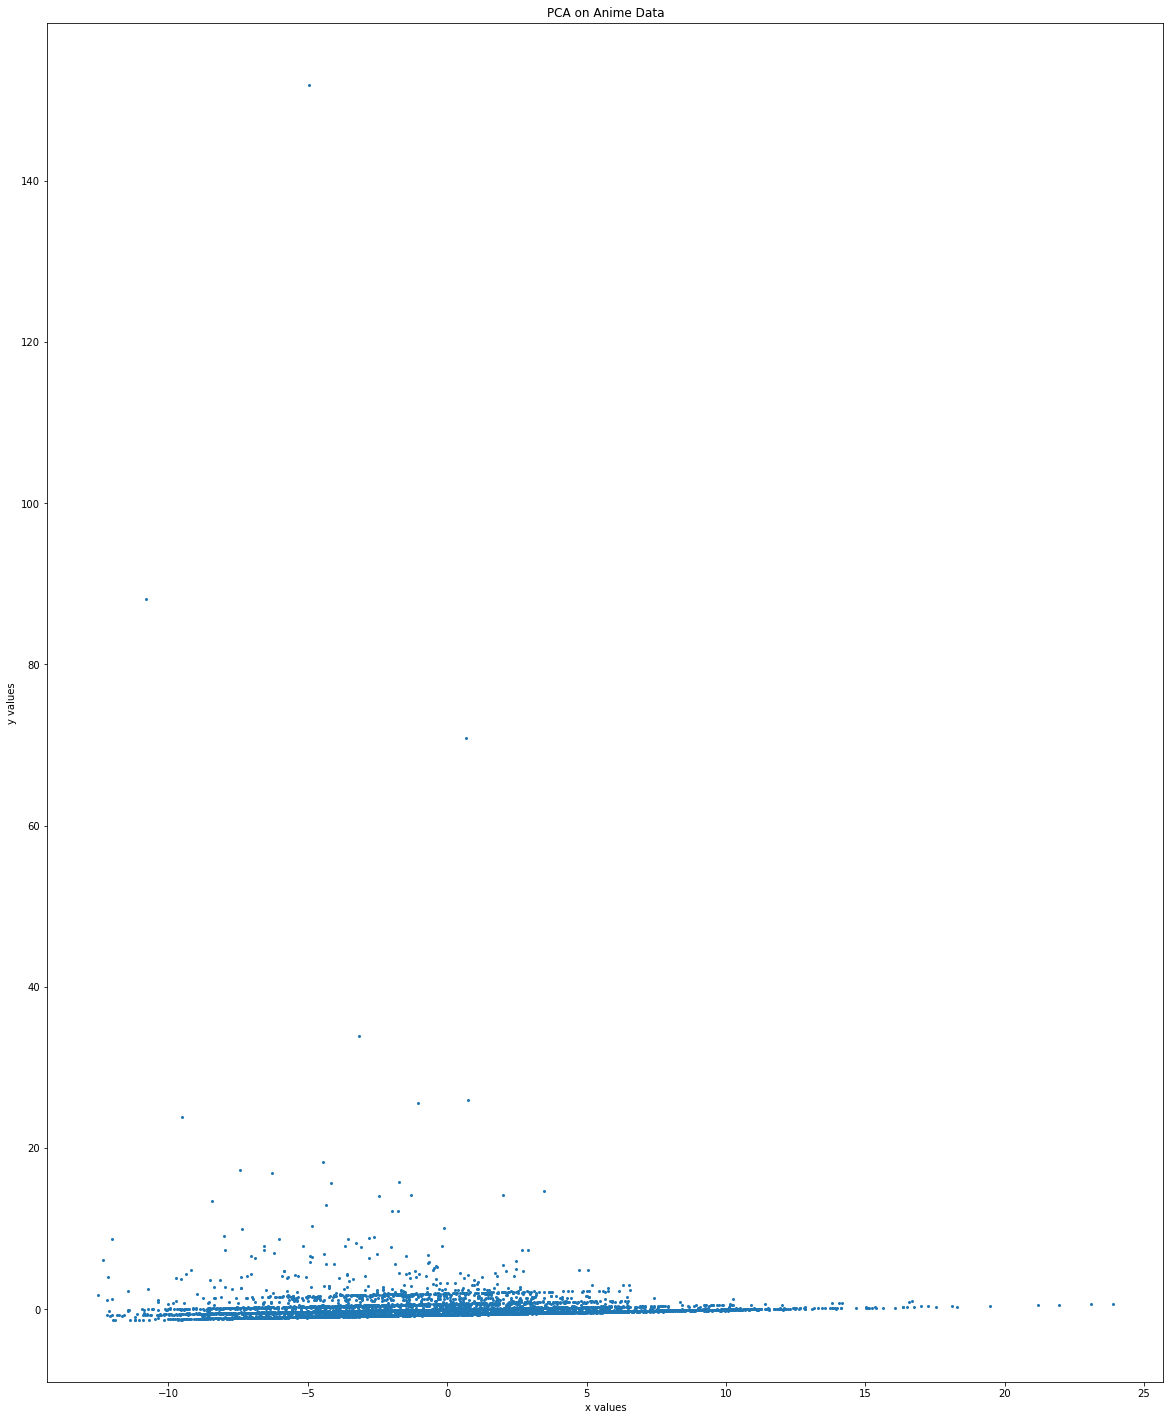

In [16]:
# Need to reduce the data from over 100 columns to 2 columns
pca_dim_red = PCA(n_components = 2)
anime_data_2d = pca_dim_red.fit_transform(anime_df)

x_data = list()
y_data = list()
# Grab the x and the y data
for i in range (0, len(anime_data_2d)):
    x_data.append(anime_data_2d[i][0])
    y_data.append(anime_data_2d[i][1])
    
# Graph the data that was derived
plt.figure(figsize = (20, 25))
plt.scatter(x_data, y_data, s = 4)
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('PCA on Anime Data')
plt.show()